In [ ]:
%conda install geoplot -c conda-forge

In [100]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
#import geoplot

In [2]:
mob = pd.read_csv('data/dataset_public.csv')
mob.head()

,organization_name,discipline_name,grid_id,discipline_id,number_researchers,pct_insiders,pct_domesticoutsiders,pct_foreignoutsiders,grid_country_code,established_year,country_name,geo_region,continent,latitude,longitude
0,Australian National University,Earth Sciences,grid.1001.0,4,173,35.838150,23.699423,40.462429,AU,1946,Australia,Oceania,Oceania,-35.2778,149.1205
1,Australian National University,All,grid.1001.0,99,2706,38.137470,23.983740,37.878788,AU,1946,Australia,Oceania,Oceania,-35.2778,149.1205
2,Australian National University,Physical Sciences,grid.1001.0,2,309,35.922329,15.857606,48.220066,AU,1946,Australia,Oceania,Oceania,-35.2778,149.1205
3,Australian National University,"Commerce, Management, Tourism and Services",grid.1001.0,15,57,40.350880,22.807016,36.842106,AU,1946,Australia,Oceania,Oceania,-35.2778,149.1205
4,Australian National University,Agricultural and Veterinary Sciences,grid.1001.0,7,45,44.444447,26.666668,28.888889,AU,1946,Australia,Oceania,Oceania,-35.2778,149.1205


In [7]:
geodist = pd.read_stata('data/geo_cepii.dta',index_col='iso2')
geodist = geodist.rename({'YU':'RS'},axis=0)
geodist = geodist[~geodist.index.duplicated(keep='first')]

#lang = geodist[all_lang_vars]
cntr_lang = geodist[all_lang_vars].apply(lambda x: list(set([col for col in x if col])), axis=1).explode()
cntr_lang = cntr_lang[mob.grid_country_code.unique()]
cntr_lang

iso2
AU      English
GB      English
ES      Spanish
ES     Galician
ES      Catalan
        ...    
CY      Turkish
SI    Slovenian
GH      English
GH         Akan
GH          Éwé
Length: 128, dtype: object

In [8]:
all_lang_vars = ['langoff_1','langoff_2','langoff_3','lang20_1','lang20_2','lang20_3','lang20_4','lang9_1',
         'lang9_2','lang9_3','lang9_4']


all_langs = pd.Series(pd.Series(geodist.loc[mob.grid_country_code.unique(),all_lang_vars].values.ravel('K')).unique())
all_langs

0                  English
1                  Spanish
2                     Thai
3                   Arabic
4                   German
              ...         
60    Napoletano-Calabrese
61                  Telugu
62                   Shoto
63                     Éwé
64                 Bengali
Length: 65, dtype: object

In [9]:
geodist.loc[mob.grid_country_code.unique(),all_lang_vars].reset_index().style

,iso2,langoff_1,langoff_2,langoff_3,lang20_1,lang20_2,lang20_3,lang20_4,lang9_1,lang9_2,lang9_3,lang9_4
0,AU,English,,,English,,,,,,,
1,GB,English,,,English,,,,,,,
2,ES,Spanish,,,Spanish,Catalan,,,Galician,,,
3,IE,English,,,English,Irish,,,,,,
4,TH,Thai,,,Thai,,,,,,,
5,EG,Arabic,,,Arabic,English,,,,,,
6,DE,German,,,German,,,,,,,
7,CZ,Czech,,,Czech,,,,,,,
8,PT,Portuguese,,,Portuguese,,,,,,,
9,MY,Malay,Chinese,,Malay,Chinese Min Nan,,,Tamoul,Chinese Yue,Chinese Hakka,


In [101]:
lang_spoken = pd.read_csv('data/languages_wiki.csv',index_col='Language')['Total speakers']
lang_spoken

Language
English                 1452000000
Spanish                  595000000
Thai                      90000000
Arabic                   360000000
German                   180000000
                           ...    
Napoletano-Calabrese             0
Telugu                    92000000
Shoto                     13500000
Éwé                       20000000
Bengali                  340000000
Name: Total speakers, Length: 64, dtype: int64

In [102]:
cntr_lang_speakers = cntr_lang.groupby('iso2').apply(lambda g: lang_spoken.loc[g.values].sum()).sort_values()
cntr_lang_speakers

iso2
IS        360000
EE       1100000
SI       2500000
LT       3000000
NO       5320000
         ...    
US    2047000000
LB    2082000000
IL    2349200000
IN    2571000000
SG    2860000000
Length: 64, dtype: int64

In [103]:
mob['mln_lang_speakers'] = mob.grid_country_code.map(cntr_lang_speakers)/1000000
mob['speakers_cat'] = pd.cut(mob.mln_lang_speakers,bins=[0,100,250,500,1000,5000])


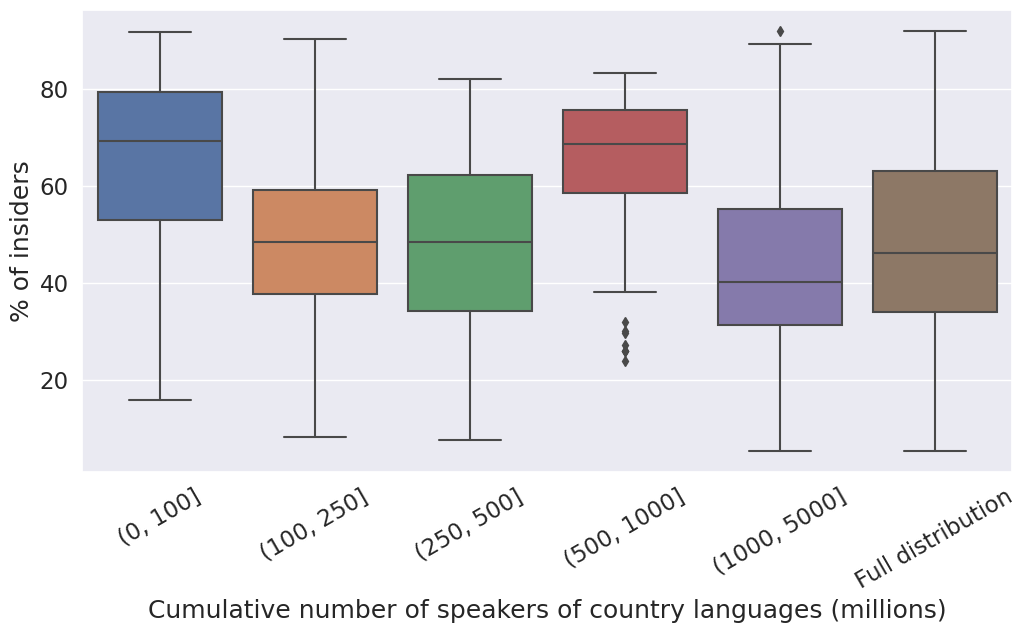

In [104]:
mob_full_dist = mob[mob.discipline_name=='All'].copy()
mob_full_dist['speakers_cat'] = 'Full distribution'
mob_fig = pd.concat([mob[mob.discipline_name=='All'],mob_full_dist])
mob_fig.speakers_cat = mob_fig.speakers_cat.astype(str)

mob

fig, ax = plt.subplots(figsize=(12,6))
sns.set(font_scale=1.5)
ax = sns.boxplot(
    data=mob_fig,
    x='speakers_cat',
    y='pct_insiders',
    ax=ax,
    order = ['(0, 100]', '(100, 250]', '(250, 500]','(500, 1000]','(1000, 5000]', 'Full distribution']
)
ax.set_ylabel('% of insiders')
ax.set_xlabel('Cumulative number of speakers of country languages (millions)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

### Table appendix

In [105]:
tbl = pd.DataFrame({
    'Speakers (mln.)':cntr_lang_speakers/1000000,
    'Languages': geodist.loc[mob.grid_country_code.unique(),all_lang_vars].apply(lambda g: ', '.join(set([lng for lng in g if lng])),axis=1)
})

tbl

,Speakers (mln.),Languages
iso2,,
AE,360.0,Arabic
AR,595.0,Spanish
AT,180.0,German
AU,1452.0,English
BE,480.0,"French, Dutch, German"
...,...,...
TW,1118.0,"Chinese Hakka, Chinese Min Nan, Chinese, Chine..."
UG,1488.0,"English, Ganda"
US,2047.0,"English, Spanish"
